# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle as pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def Explore(df):
        print('DataFrame Shape : \n')
        print(df.shape)
        print('DataFrame examples : \n')
        print(df.head())
        print('DataFrame Description : \n')
        print(df.describe())

In [3]:
def Cleaning_dataframe(df,azdias=True,cust=True):
    
    if cust:
        df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
    elif azdias:
        df=df[df.isnull().sum(axis=1) <= 16]
    
    df_null_count=df.isnull().sum()*100/len(df)
    
    drop_columns_list=df.columns[(df_null_count/100) > .30]
    drop_columns_list=list(drop_columns_list)
    print('columns to drop : ',drop_columns_list)
    
    df=df.drop(drop_columns_list,axis=1)
    
    
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
    df = df.drop(['CAMEO_DEU_2015'],axis=1)
    return df

In [4]:
def Handle_category_values(df):
    df['CAMEO_DEUG_2015']=df['CAMEO_DEUG_2015'].replace('X',np.NaN)
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].replace('XX',np.NaN)
    df['CAMEO_DEUG_2015'].fillna(-1, inplace=True)
    df['CAMEO_INTL_2015'].fillna(-1, inplace=True)
    df['OST_WEST_KZ'].fillna(-1, inplace=True)
    df['CAMEO_DEUG_2015']=df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)
    df['OST_WEST_KZ'] = df.OST_WEST_KZ.map({'W':0,'O':1})
    return df

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Explore(azdias)

DataFrame Shape : 

(891221, 366)
DataFrame examples : 

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND

In [7]:
Explore(customers)

DataFrame Shape : 

(191652, 369)
DataFrame examples : 

      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLA

In [8]:
mixed_cols=azdias.columns[18:20]
mixed_cols

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [9]:
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']


after checking dias attributes i found that -1 means this value is unknown or missing

In [10]:
obj_cols=azdias.select_dtypes('object').columns
obj_cols

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [11]:
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [12]:
for col in obj_cols:
    print('{} column has {} unique values'.format(col,azdias[col].nunique()))

CAMEO_DEU_2015 column has 45 unique values
CAMEO_DEUG_2015 column has 19 unique values
CAMEO_INTL_2015 column has 43 unique values
D19_LETZTER_KAUF_BRANCHE column has 35 unique values
EINGEFUEGT_AM column has 5162 unique values
OST_WEST_KZ column has 2 unique values


In [13]:
print(azdias['D19_LETZTER_KAUF_BRANCHE'].head())

0              NaN
1              NaN
2    D19_UNBEKANNT
3    D19_UNBEKANNT
4       D19_SCHUHE
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object


In [14]:
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())
print(azdias['OST_WEST_KZ'].unique())
print(azdias['D19_LETZTER_KAUF_BRANCHE'].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
[nan 'W' 'O']
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAE

the above cells shows that D19_LETZTER_KAUF_BRANCHE has many unique values and after checking the dias attributes and dias info excel sheets i found no discribtion for it so i decided to drop it ,EINGEFUEGT_AM  has significant number of mising values so should be dropped,also CAMEO_DEU_2015 column has many unique values and in the description it is like the CAMEO_DEUG_2015 column so i decided to drop it toom deug and intl columns has mixed values should be handled 

In [7]:
azdias=Handle_category_values(azdias)

In [16]:
print(azdias['CAMEO_DEU_2015'].head())

0    -1
1    8A
2    4C
3    2A
4    6B
Name: CAMEO_DEU_2015, dtype: object


In [8]:
customers=Handle_category_values(customers)

In [18]:
azdias_null_count=azdias.isnull().sum()*100/len(azdias)

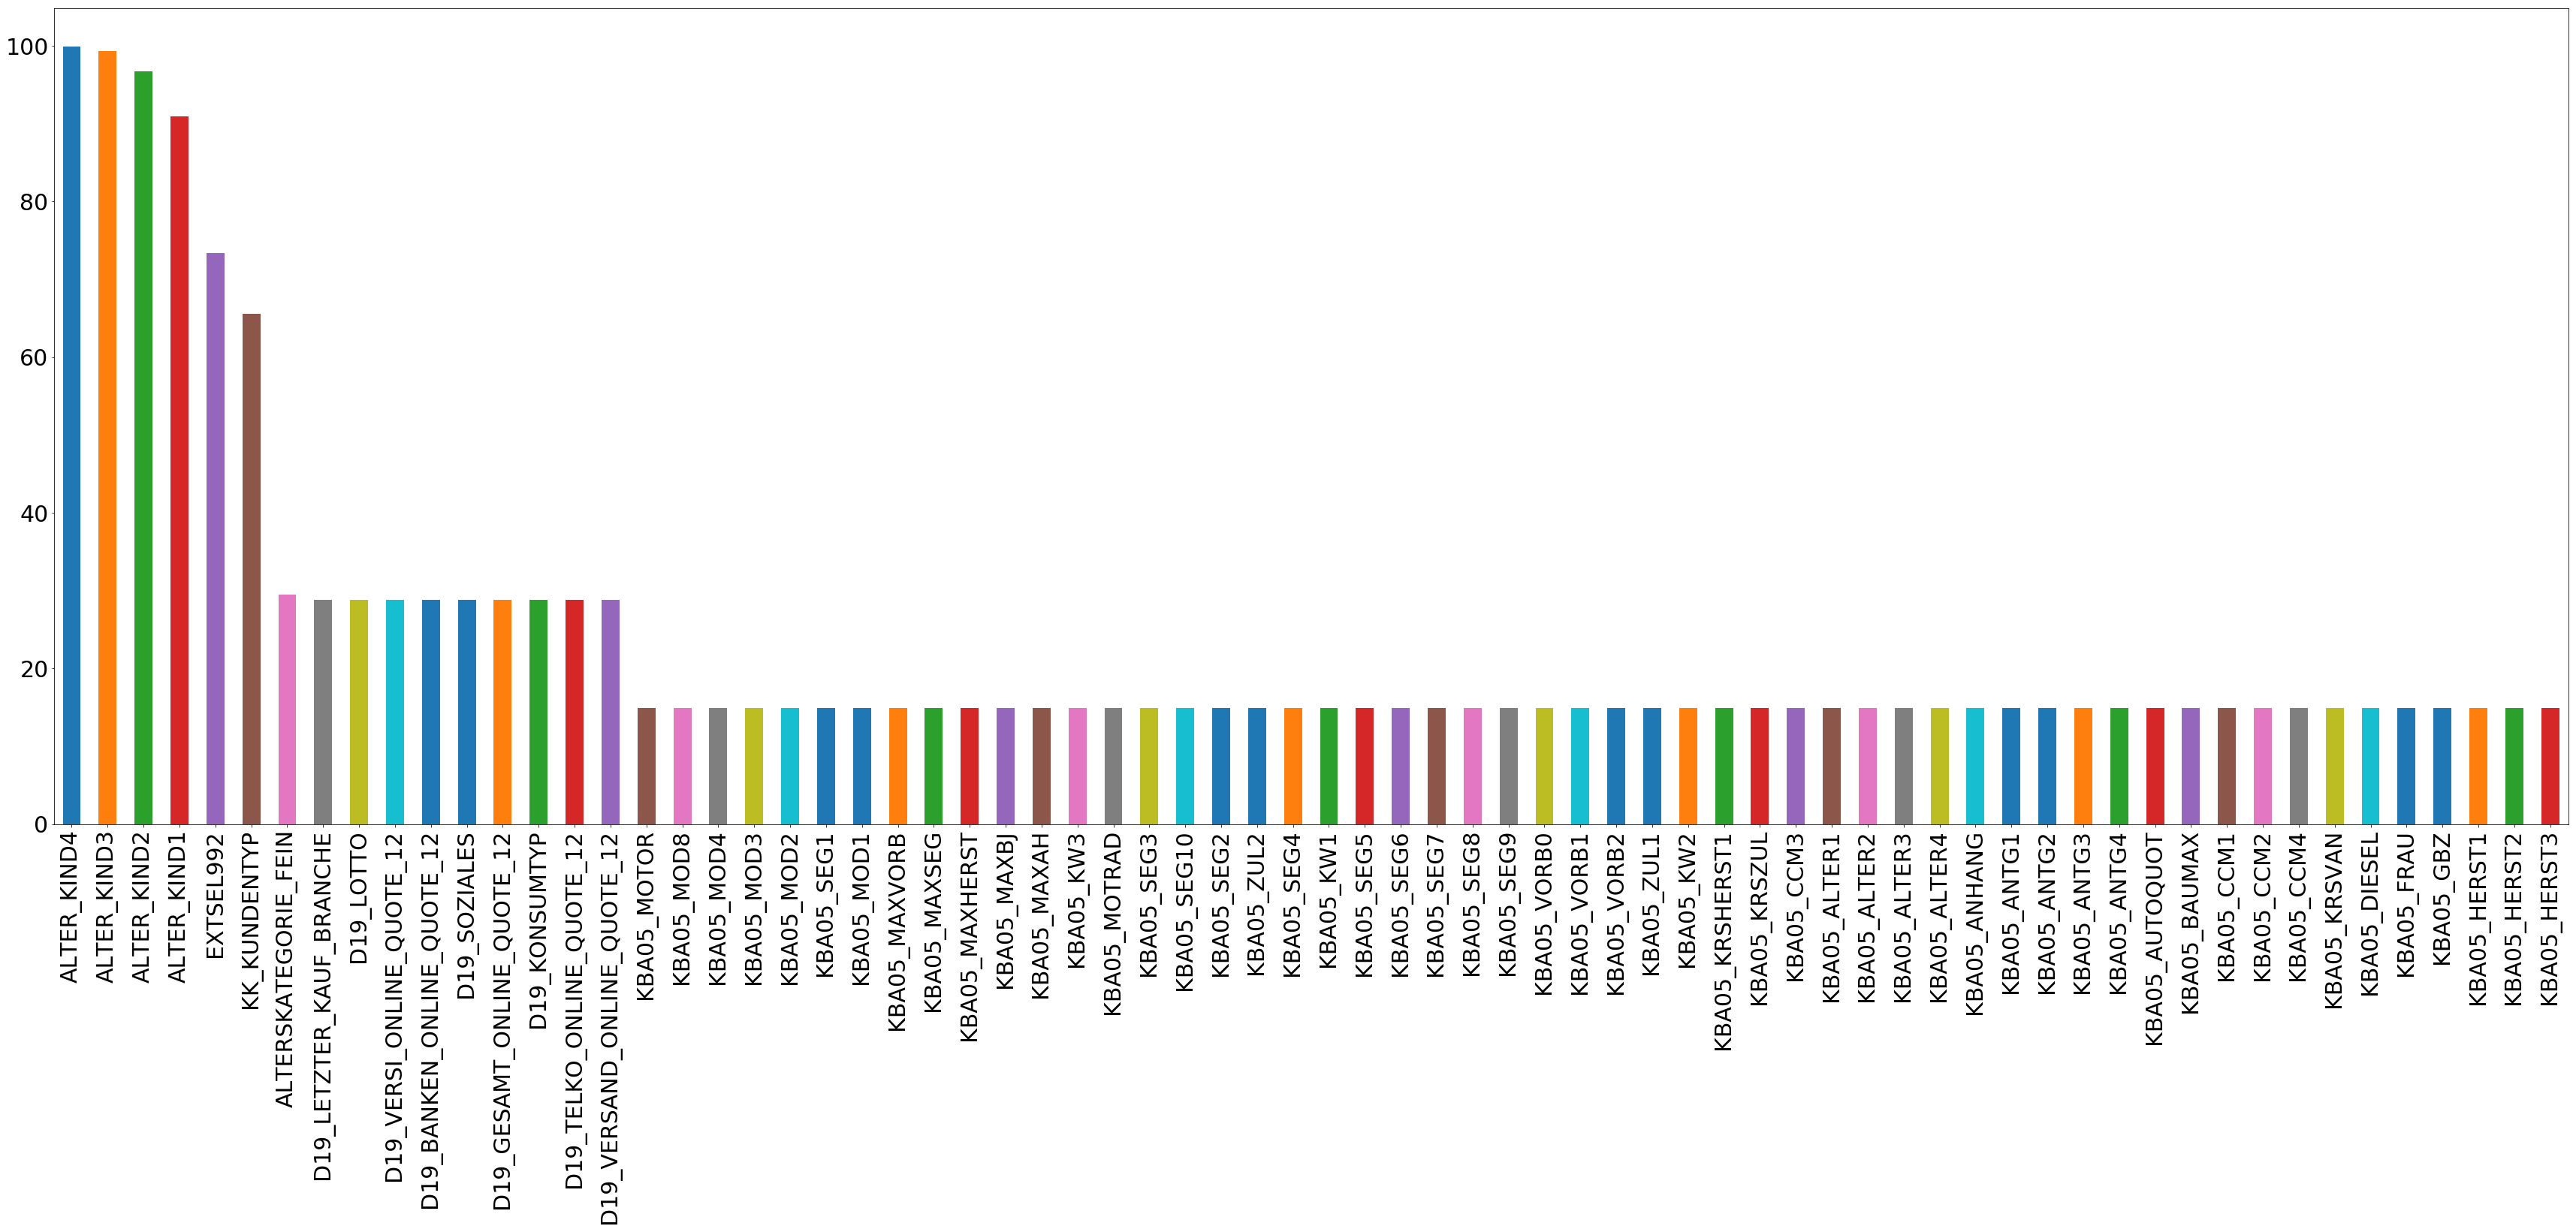

In [19]:
miss_azdias_plot=azdias_null_count.sort_values(ascending=False).head(70).plot(kind='bar',figsize=(60,20),fontsize=30)

In [20]:
azdias_null_count.sort_values(ascending=False)[0:20]


ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64

In [21]:
azdias_null_count.describe()

count    366.000000
mean      10.176984
std       12.199039
min        0.000000
25%        0.000000
50%       11.871354
75%       12.023000
max       99.864792
dtype: float64

In [22]:
print('{} columns having missing values > 90% of {} total columns'.format(len(azdias.columns[azdias_null_count/100 > .90]),len(azdias.columns)))
print('{} columns having missing values > 50% of {} total columns'.format(len(azdias.columns[azdias_null_count/100 > .50]),len(azdias.columns)))
print('{} columns having missing values > 30% of {} total columns'.format(len(azdias.columns[azdias_null_count/100 > .30]),len(azdias.columns)))
print('{} columns having missing values > 25% of {} total columns'.format(len(azdias.columns[azdias_null_count/100 > .25]),len(azdias.columns)))


4 columns having missing values > 90% of 366 total columns
6 columns having missing values > 50% of 366 total columns
6 columns having missing values > 30% of 366 total columns
16 columns having missing values > 25% of 366 total columns


In [23]:
drop_columns_list=azdias.columns[(azdias_null_count/100) > .30]
drop_columns_list=list(drop_columns_list)
drop_columns_list

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [24]:
#for rows
azdias_row_null_count=azdias.isnull().sum(axis=1)
azdias_row_null_count.describe()

count    891221.000000
mean         37.247760
std          74.405408
min           0.000000
25%           5.000000
50%           6.000000
75%          16.000000
max         256.000000
dtype: float64

In [25]:
#from the previouse stats we conclude that about 75% of data have 16 mising values or less
#so we test for the percent of data containing around this number as a threshold
for i in range(10,25):
    print('percent of data have {} missing columns or less = {}'.format(i,round(sum(azdias_row_null_count <=i)*100/len(azdias))))

percent of data have 10 missing columns or less = 64
percent of data have 11 missing columns or less = 64
percent of data have 12 missing columns or less = 65
percent of data have 13 missing columns or less = 65
percent of data have 14 missing columns or less = 65
percent of data have 15 missing columns or less = 73
percent of data have 16 missing columns or less = 82
percent of data have 17 missing columns or less = 83
percent of data have 18 missing columns or less = 83
percent of data have 19 missing columns or less = 84
percent of data have 20 missing columns or less = 84
percent of data have 21 missing columns or less = 84
percent of data have 22 missing columns or less = 84
percent of data have 23 missing columns or less = 84
percent of data have 24 missing columns or less = 84


In [26]:
customers_row_null_count=customers.isnull().sum(axis=1)
customers_row_null_count.describe()

count    191652.000000
mean         71.552804
std         106.299784
min           0.000000
25%           4.000000
50%           5.000000
75%         222.000000
max         256.000000
dtype: float64

In [27]:
for i in range(10,25):
    print('percent of data have {} missing columns or less = {}'.format(i,round(sum(customers_row_null_count <=i)*100/len(customers))))

percent of data have 10 missing columns or less = 68
percent of data have 11 missing columns or less = 68
percent of data have 12 missing columns or less = 68
percent of data have 13 missing columns or less = 68
percent of data have 14 missing columns or less = 68
percent of data have 15 missing columns or less = 69
percent of data have 16 missing columns or less = 69
percent of data have 17 missing columns or less = 69
percent of data have 18 missing columns or less = 69
percent of data have 19 missing columns or less = 69
percent of data have 20 missing columns or less = 69
percent of data have 21 missing columns or less = 69
percent of data have 22 missing columns or less = 69
percent of data have 23 missing columns or less = 69
percent of data have 24 missing columns or less = 69


In [9]:
azdias=Cleaning_dataframe(azdias,azdias=True,cust=False)
azdias.shape

columns to drop :  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


(733327, 357)

In [10]:
customers=Cleaning_dataframe(customers,azdias=False,cust=True)
customers.shape

columns to drop :  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


(191652, 357)

In [11]:
azdias=azdias.drop('LNR',axis=1)
customers=customers.drop('LNR',axis=1)

In [50]:
azdias.shape

(733327, 356)

In [51]:
obj_cols=azdias.select_dtypes('object').columns
obj_cols

Index([], dtype='object')

In [52]:
azdias.shape

(733327, 356)

In [12]:
azdias=azdias.astype(float)
customers=customers.astype(float)

In [13]:
imputer = Imputer(strategy='most_frequent')
azdias_col=list(azdias.columns.values)
azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias,columns=azdias_col)
print('imputed azdias: ', azdias.head(5))

customers_col=list(customers.columns.values)
customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers,columns=customers_col)
print('imputed customers: ', customers.head(5))

imputed azdias:     AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0      -1.0         9.0       0.0                  21.0                 11.0   
1      -1.0         9.0      17.0                  17.0                 10.0   
2       2.0         1.0      13.0                  13.0                  1.0   
3      -1.0         1.0      20.0                  14.0                  3.0   
4       3.0         1.0      10.0                  10.0                  5.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                        12.0   
1           0.0         0.0           1.0                         7.0   
2           0.0         0.0           0.0                         2.0   
3           0.0         0.0           4.0                         3.0   
4           0.0         0.0           1.0                         2.0   

   ANZ_TITEL          ...           VHN  VK_DHT4A  VK_DISTANZ  

In [14]:
#there is a way to get columns in dataframe of a correlation higher than a specific threshold
#according to https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

#for azdias dataframe
corr_matrix = azdias.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('azdias high correlated columns to drop : \n',to_drop)
azdias=azdias.drop(to_drop,axis=1)

#for customers dataframe
corr_matrix = customers.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('customers high correlated columns to drop : \n',to_drop)
customers=customers.drop(to_drop,axis=1)

azdias high correlated columns to drop : 
 ['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'D19_GESAMT_ANZ_24', 'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSHERST3', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']
customers high correlated columns to drop : 
 ['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_TYP_2', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'ORTSGR_KLS9', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_ZG11']


In [56]:
print(azdias.shape)
print(customers.shape)

(733327, 333)
(191652, 334)


In [15]:
#normalize data
scaler=StandardScaler()
azdias_col=list(azdias.columns.values)
azdias=pd.DataFrame(scaler.fit_transform(azdias))
azdias.columns=azdias_col
customers_col=list(customers.columns.values)
customers=pd.DataFrame(scaler.fit_transform(customers))
customers.columns=customers_col

In [16]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.575673,1.243365,-1.431126,1.564774,0.160606,-0.128444,-0.298712,0.214938,-0.060847,-0.188551,...,1.366865,0.700026,1.070745,1.467448,-0.589593,0.547723,-0.027030,1.143452,0.957221,-1.684440
1,-0.575673,1.243365,0.802134,0.675967,0.096492,-0.128444,-0.298712,-0.651211,-0.060847,-0.188551,...,-0.359507,1.050263,0.456879,0.032818,-0.589593,0.547723,-1.084218,1.143452,0.957221,0.164738
2,1.849078,-0.948717,0.276661,-0.212840,-0.480541,-0.128444,-0.298712,-1.517360,-0.060847,-1.193644,...,-2.085878,0.349790,0.763812,1.826106,0.994053,0.547723,1.558753,-0.281033,0.957221,1.089327
3,-0.575673,-0.948717,1.196238,0.009362,-0.352312,-0.128444,-0.298712,1.947237,-0.060847,0.816542,...,-0.359507,-1.051157,-0.770854,-0.684497,-1.117475,0.547723,-0.555624,0.431210,-1.044690,0.164738
4,2.657328,-0.948717,-0.117444,-0.879445,-0.224082,-0.128444,-0.298712,-0.651211,-0.060847,-1.193644,...,-0.359507,1.400500,-0.156988,-0.684497,0.994053,0.547723,1.558753,0.431210,0.957221,-1.684440


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

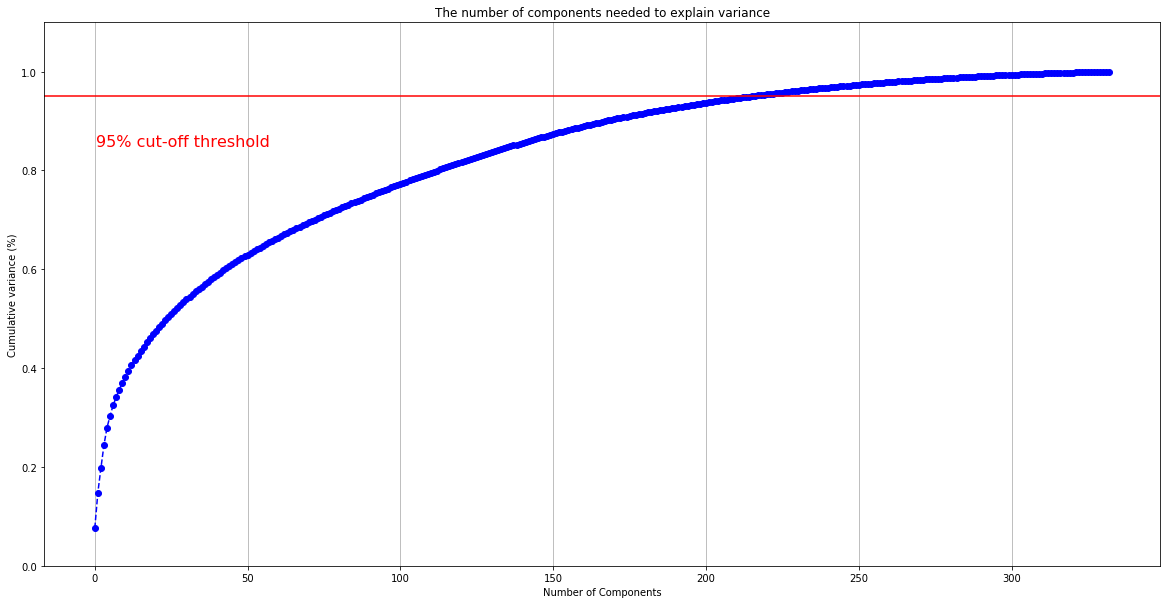

In [59]:
pca = PCA().fit(azdias)
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [65]:
def reduce_data(df,comp_number=230):
    pca = PCA(n_components=comp_number).fit(df)
    reduced_data = pca.transform(df)
    with open('pca.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return pca,reduced_data

In [68]:
_,reduced_customers = reduce_data(customers)
pca_model,reduced_azdias = reduce_data(azdias)

0.958344163003
0.959930496986


In [94]:
print(reduced_azdias.shape)
print(reduced_customers.shape)

(733327, 230)
(191652, 230)


In [5]:
with open('pca.pkl', 'rb') as pickle_file:
    pca_model = pickle.load(pickle_file)

In [70]:
reduced_azdias.to_pickle('pca_azdias.pickle')
reduced_customers.to_pickle('pca_customers.pickle')

In [6]:
pca_azdias = pd.read_pickle('pca_azdias.pickle')
pca_customers = pd.read_pickle('pca_customers.pickle')

In [7]:
pca_azdias.head(5)

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
0,-1.000023,-5.186488,4.300307,-4.386044,-4.340650,1.132570,-2.136208,3.107988,0.027291,0.181943,...,-0.438474,-0.664531,-0.405082,0.625657,-0.071827,0.306718,-0.350463,-0.688858,0.544537,0.460515
1,-0.496418,0.424785,0.536721,-3.453316,-2.985621,3.714294,-3.683109,-3.316805,0.215200,0.344947,...,0.477547,-0.353835,0.288281,0.046740,0.123005,-0.145642,0.294937,0.366288,-0.192402,-0.295661
2,1.078947,5.085777,-4.157769,-1.205890,-3.743275,-0.753332,-1.093128,0.515817,-3.660457,0.111902,...,-0.308408,0.074494,-0.218622,0.881065,0.621962,-0.055637,0.475238,-0.289431,0.128616,0.122836
3,-1.195386,3.906850,5.632391,-1.197152,8.038112,-3.155957,3.316901,-0.610400,-3.705033,6.422978,...,0.050410,0.664191,0.002912,0.245019,-0.506362,-0.168595,0.812315,-0.033713,0.859856,-0.293980
4,-0.148332,2.825582,-1.626631,-2.208079,-2.423628,1.145406,0.363662,1.235383,-0.737189,2.060835,...,-0.585778,-0.257875,0.387006,-0.744071,-0.311351,0.292031,0.560780,0.675339,-0.108376,0.351845


In [7]:
attributes_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [59]:
with open("preprocessed_azdias_cols.txt", "wb") as fp:   #Pickling
    pickle.dump(list(azdias.columns.values), fp)


In [8]:
with open("preprocessed_azdias_cols.txt", "rb") as fp:   # Unpickling
    azdias_cols = pickle.load(fp)

In [11]:
def component_stats(pca_model, component):

    weights_array = pca_model.components_[component]
    df_features = pd.DataFrame({'Features' : azdias_cols,'Weight' : weights_array})
    df_features.sort_values(by='Weight',inplace=True, ascending=False)
    
    feature_names = []
    feature_weights = []
    feature_descriptions=[]

    for feature,weight in df_features[:5].itertuples(index=False):
        feature_names.append(feature)
        feature_weights.append(weight)
        
    for feature, weight, in df_features[-5:].itertuples(index=False):
        feature_names.append(feature)
        feature_weights.append(weight)
        
    for feature in feature_names:
        if feature in attributes_info.Attribute.values:
            feature_descriptions.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feature_descriptions.append("unknown")
            
    df_features1 = pd.DataFrame({'Features' : feature_names,'Weight' : feature_weights,'Descriptions' : feature_descriptions})
           
    return df_features1

In [12]:
component_0 = component_stats(pca_model, 2)
component_0

,Features,Weight,Descriptions
0,PRAEGENDE_JUGENDJAHRE,0.195279,dominating movement in the person's youth (ava...
1,CJT_TYP_1,0.188379,unknown
2,CJT_TYP_2,0.187733,unknown
3,FINANZ_SPARER,0.183417,financial typology: money saver
4,ONLINE_AFFINITAET,0.162259,online affinity
5,FINANZ_UNAUFFAELLIGER,0.161608,financial typology: unremarkable
6,ALTERSKATEGORIE_FEIN,0.156665,unknown
7,SEMIO_PFLICHT,0.155770,affinity indicating in what way the person is ...
8,SEMIO_TRADV,0.153463,affinity indicating in what way the person is ...
9,FINANZ_ANLEGER,0.149143,financial typology: investor


In [13]:
component_1= component_stats(pca_model, 8)
component_1

,Features,Weight,Descriptions
0,KBA13_KMH_140_210,0.204518,share of cars with max speed between 140 and 2...
1,KBA13_CCM_1401_2500,0.176740,unknown
2,KBA13_ALTERHALTER_61,0.165377,share of car owners elder than 60 within the PLZ8
3,KBA13_HALTER_65,0.157145,share of car owners between 61 and 65 within t...
4,KBA13_SEG_VAN,0.149803,share of vans within the PLZ8
5,KBA13_SEG_GROSSRAUMVANS,0.141179,share of big sized vans within the PLZ8
6,KBA13_VORB_1_2,0.137708,share of cars with 1 or 2 preowner - PLZ8
7,KBA13_SEG_MINIVANS,0.130160,share of minivans within the PLZ8
8,KBA13_KRSHERST_FORD_OPEL,0.130085,share of FORD/Opel (referred to the county ave...
9,KBA13_KRSSEG_VAN,0.123337,share of vans (referred to the county average)...


In [220]:
component_2 = component_stats(pca_model, 2)
component_2

,Features,Weight,Descriptions
0,PRAEGENDE_JUGENDJAHRE,0.195279,dominating movement in the person's youth (ava...
1,CJT_TYP_1,0.188379,unknown
2,CJT_TYP_2,0.187733,unknown
3,FINANZ_SPARER,0.183417,financial typology: money saver
4,ONLINE_AFFINITAET,0.162259,online affinity
5,ALTERSKATEGORIE_GROB,-0.167307,age through prename analysis
6,CJT_TYP_3,-0.170254,unknown
7,CJT_TYP_4,-0.173553,unknown
8,FINANZ_VORSORGER,-0.174465,financial typology: be prepared
9,CJT_TYP_5,-0.177167,unknown


In [114]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_azdias.sample(30000))
    distortions.append(kmeanModel.inertia_)

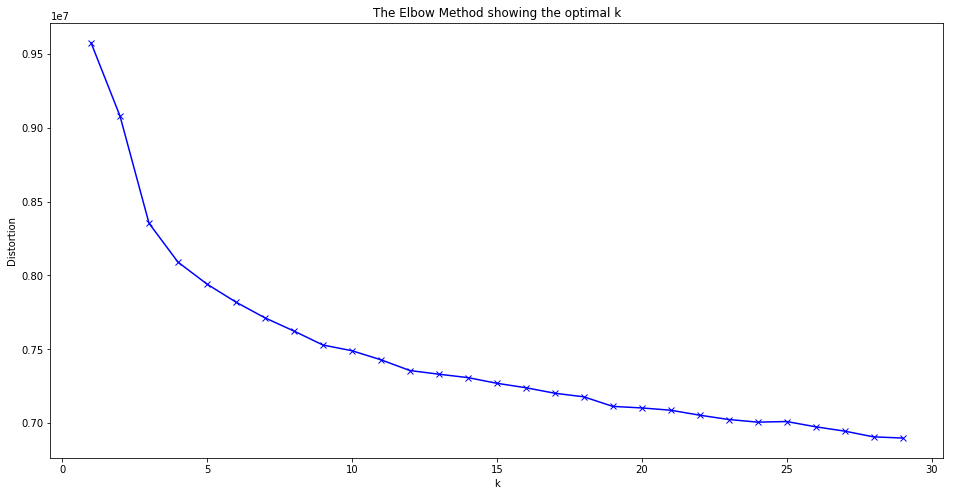

In [115]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [26]:
kmeanModel = KMeans(9)
model_k = kmeanModel.fit(pca_azdias)
pickle.dump(model_k, open("kmeans_model.pkl", "wb"))

In [29]:
model_k = pickle.load(open("kmeans_model.pkl", "rb"))

In [ ]:
azdias_clustered = pd.DataFrame(model_k.predict(pca_azdias), columns = ['Cluster'])
customers_clustered = pd.DataFrame(model_k.predict(pca_customers), columns = ['Cluster'])

In [18]:
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')

In [30]:
azdias_clustered = pd.read_pickle('azdias_clustered')
customers_clustered = pd.read_pickle('customers_clustered')

In [31]:
customer_clusters = pd.Series(customers_clustered['Cluster']).value_counts().sort_index()
population_clusters = pd.Series(azdias_clustered['Cluster']).value_counts().sort_index()
mixed_stats=pd.concat([population_clusters,customer_clusters],axis=1).reset_index()
mixed_stats.columns=['cluster','population','customer']
mixed_stats

,cluster,population,customer
0,0,76142,5896.0
1,1,118282,82065.0
2,2,98032,12199.0
3,3,118094,31994.0
4,4,39518,2586.0
5,5,105135,32363.0
6,6,67083,12534.0
7,7,97783,12015.0
8,8,13258,NaN


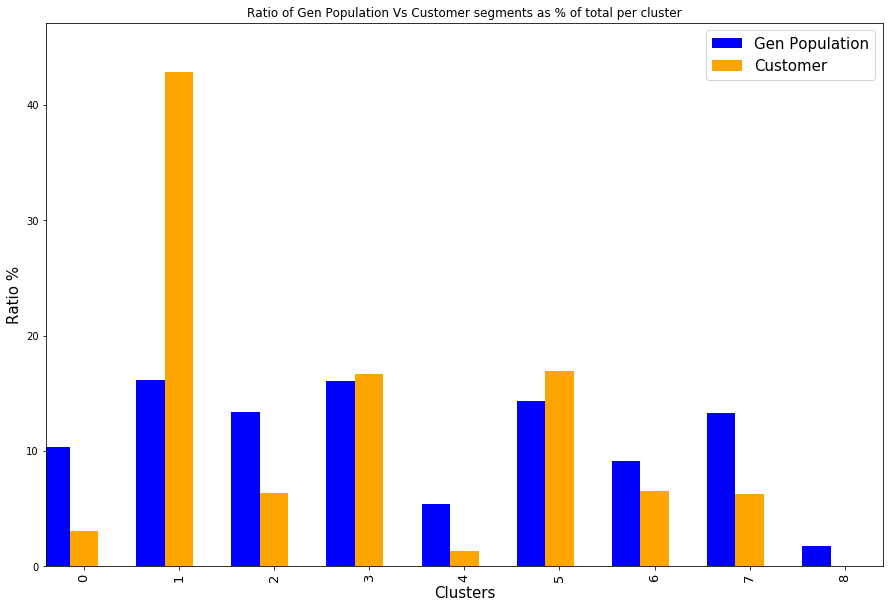

In [35]:
mixed_stats['pop_percent'] = (mixed_stats['population']/mixed_stats['population'].sum()*100).round(2)
mixed_stats['cust_percent'] = (mixed_stats['customer']/mixed_stats['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
ax = mixed_stats['pop_percent'].plot(x=mixed_stats['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = mixed_stats['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [241]:
def cluster_specs(kmeans_model, cluster_no, pca_model):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    comp_info = []
    
    for index, row in cluster_expl.head(2).iterrows():
        component_info = component_stats(pca_model, int(row["Component"]))
        comp_info.append(component_info)
        comps += [int(row["Component"])] * len(component_info)

    component_info = pd.concat(comp_info, ignore_index=True)
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [242]:
cluster_1 = cluster_specs(model_k, 1, pca_model)
cluster_1

,Component,Features,Weight,Descriptions
0,2,PRAEGENDE_JUGENDJAHRE,0.195279,dominating movement in the person's youth (ava...
1,2,CJT_TYP_1,0.188379,unknown
2,2,CJT_TYP_2,0.187733,unknown
3,2,FINANZ_SPARER,0.183417,financial typology: money saver
4,2,ONLINE_AFFINITAET,0.162259,online affinity
5,2,ALTERSKATEGORIE_GROB,-0.167307,age through prename analysis
6,2,CJT_TYP_3,-0.170254,unknown
7,2,CJT_TYP_4,-0.173553,unknown
8,2,FINANZ_VORSORGER,-0.174465,financial typology: be prepared
9,2,CJT_TYP_5,-0.177167,unknown


In [231]:
cluster_3 = cluster_specs(model_k, 3, pca_model)
cluster_3

,Component,Features,Weight,Descriptions
0,1,MOBI_REGIO,0.153979,moving patterns
1,1,KBA13_ANTG1,0.146132,unknown
2,1,LP_STATUS_FEIN,0.144552,social status fine
3,1,KBA05_ANTG1,0.142356,number of 1-2 family houses in the cell
4,1,MOBI_RASTER,0.141025,unknown
5,1,HH_EINKOMMEN_SCORE,-0.137772,estimated household_net_income
6,1,KBA13_BAUMAX,-0.140492,unknown
7,1,PLZ8_ANTG4,-0.140890,number of >10 family houses in the PLZ8
8,1,KBA13_ANTG4,-0.141919,unknown
9,1,KBA13_ANTG3,-0.145805,unknown


In [232]:
cluster_5 = cluster_specs(model_k, 5, pca_model)
cluster_5

,Component,Features,Weight,Descriptions
0,4,D19_GESAMT_ANZ_12,0.140064,unknown
1,4,EWDICHTE,0.124501,density of inhabitants per square kilometer
2,4,KBA13_ANTG4,0.117606,unknown
3,4,D19_GESAMT_ONLINE_QUOTE_12,0.117062,amount of online transactions within all trans...
4,4,KBA13_ANTG3,0.116970,unknown
5,4,D19_GESAMT_ONLINE_DATUM,-0.138316,actuality of the last transaction with the com...
6,4,VK_ZG11,-0.146036,unknown
7,4,D19_KONSUMTYP,-0.150581,consumption type
8,4,D19_GESAMT_DATUM,-0.152219,actuality of the last transaction with the com...
9,4,VK_DISTANZ,-0.153777,unknown


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [7]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
x=mailout_train.drop('RESPONSE',axis=1)
y=mailout_train['RESPONSE']

In [9]:
x=Handle_category_values(x)

In [10]:
print(x.shape)
print(y.shape)

(42962, 366)
(42962,)


In [11]:
x=Cleaning_dataframe(x,azdias=False,cust=False)
x.head(5)

columns to drop :  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [12]:
x=x.drop('LNR',axis=1)

In [13]:
print(x.shape)
print(y.shape)

(42962, 356)
(42962,)


In [14]:
cat_cols = list(x.select_dtypes(['object']).columns)
cat_cols

[]

In [16]:
x = x.astype(float)

In [17]:
imputer = Imputer(strategy='most_frequent')
x_col=list(x.columns.values)
x = imputer.fit_transform(x)
x = pd.DataFrame(x,columns=x_col)
print('imputed mailout: ', x.head(5))

imputed mailout:     AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0       2.0         1.0       8.0                   8.0                 15.0   
1       1.0         4.0      13.0                  13.0                  1.0   
2       1.0         1.0       9.0                   7.0                  0.0   
3       2.0         1.0       6.0                   6.0                  4.0   
4       2.0         1.0       9.0                   9.0                 53.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           1.0                        13.0   
1           0.0         0.0           2.0                         1.0   
2           0.0         0.0           0.0                         1.0   
3           0.0         0.0           2.0                         4.0   
4           0.0         0.0           1.0                        44.0   

   ANZ_TITEL          ...           VHN  VK_DHT4A  VK_DISTANZ 

In [18]:
corr_matrix = x.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
x=x.drop(to_drop,axis=1)

In [19]:
#normalize data
scaler=StandardScaler()
x=pd.DataFrame(scaler.fit_transform(x.astype(float)))

In [20]:
x.to_pickle('mailout_train_features.pickle')
y.to_pickle('mailout_train_labels.pickle')

In [5]:
x=pd.read_pickle('mailout_train_features.pickle')
y=pd.read_pickle('mailout_train_labels.pickle')

In [6]:
print(x.shape)
print(y.shape)

(42962, 333)
(42962,)


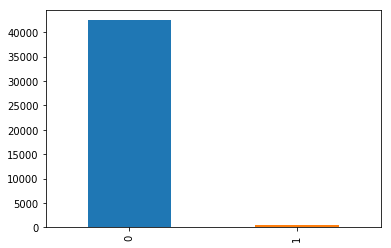

In [7]:
y.value_counts().plot.bar();

In [24]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [8]:
random = RandomForestClassifier()
logreg = LogisticRegression()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
gnb=GaussianNB()

In [26]:
class_list = [random,logreg,abc,gbc,gnb]
for model in class_list:
        start = time.time()
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='roc_auc', cv=5, n_jobs=-1,verbose=3)
        grid.fit(x, y)
        end = time.time()
        print(model, '\n', grid.best_score_,'\n', round(end-start))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.5201458807359455, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.4920066255360671, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.4915988153629285, total=   1.5s
[CV]  ................................................................
[CV] ....................... , score=0.5177267552772824, total=   1.6s
[CV]  ................................................................
[CV] ....................... , score=0.5551407645889567, total=   1.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 0.515323337803 
 10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.6419974845870382, total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ....................... , score=0.6572496536351242, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


[CV] ....................... , score=0.6908682002321249, total=   9.3s
[CV]  ................................................................
[CV] ....................... , score=0.6693116075756296, total=   9.6s
[CV]  ................................................................
[CV] ....................... , score=0.6750168979762451, total=   9.7s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 0.666887965058 
 61
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.7052467946105845, total=  14.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV] ....................... , score=0.7235766000515417, total=  14.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   30.3s remaining:    0.0s


[CV] ....................... , score=0.7862233690117797, total=  14.6s
[CV]  ................................................................
[CV] ....................... , score=0.7212034027187953, total=  14.8s
[CV]  ................................................................
[CV] ....................... , score=0.7286857598975449, total=  14.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
 0.732986320518 
 95
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.7230281431098169, total=  43.1s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   43.3s remaining:    0.0s


[CV] ....................... , score=0.7272412395567411, total=  43.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] ....................... , score=0.7968785435723211, total=  43.2s
[CV]  ................................................................
[CV] ....................... , score=0.7510122110112549, total=  42.5s
[CV]  ................................................................
[CV] ....................... , score=0.7557019552737249, total=  42.9s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 
 0.750771224998 
 271
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.5782178893879087, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ....................... , score=0.5933874594989879, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.663909813722046, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.5988614988504929, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.6243357538943164, total=   0.4s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


GaussianNB(priors=None) 
 0.611741275501 
 4


In [27]:
param_grid = {'learning_rate': [0.01, 0.1,1.0],
              'n_estimators': [50,100,150]}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

best = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1,verbose=3)
best.fit(x, y)

print(best.best_score_,best.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV]  learning_rate=0.01, n_estimators=50, score=0.765464730349789, total=  12.0s
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, score=0.756008742022066, total=  11.9s
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.7s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, score=0.7402933554800023, total=  11.9s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.7646111504779094, total=  24.2s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.756008742022066, total=  23.7s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.754812925761122, total=  24.0s
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV]  learning_rate=0.01, n_estimators=150, score=0.7646111504779094, total=  35.7s
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV]  learning_rate=0.01, n_estimators=150, score=0.7564166018525066, total=  35.7s
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV]  learning_rate=0.01, n_estimators=150, score=0.7562176653240449, tot

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 11.1min finished


0.764472545158 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


In [9]:
param_grid = {'learning_rate': [0.01,0.1,1.0],
              'n_estimators': [50, 100,150],
              'max_depth': [3,5],
              'min_samples_split' : [2,4]}

best = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1,verbose=3)
best.fit(x, y)

print(best.best_score_,best.best_estimator_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50, score=0.7408211366871726, total=  20.7s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50, score=0.7755450681117927, total=  20.8s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.7s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50, score=0.7499785284369381, total=  21.3s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, score=0.7370838947074076, total=  41.4s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, score=0.7870672081894738, total=  41.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, score=0.7501017652221396, total=  41.8s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150, score=0.7396186178122934, total= 1.0min
[CV] learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=0.01, 

[CV]  learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=100, score=0.7358688640754486, total=  35.6s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=100, score=0.7763226382978383, total=  35.8s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=100, score=0.7442750820812917, total=  34.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=150 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=150, score=0.7325198837637907, total=  52.7s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=150 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=150, score=0.7691617222150985, total=  53.7s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=4, n_estimators=150 
[CV]  learning_rate=0.1, max_depth=

[CV]  learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=50, score=0.6024978518450165, total=  39.6s
[CV] learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=50 
[CV]  learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=50, score=0.5910649935225787, total=  35.8s
[CV] learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100, score=0.6227169022319388, total= 1.0min
[CV] learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100, score=0.6490174413007412, total=  54.3s
[CV] learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=100, score=0.5948344013188933, total=  54.6s
[CV] learning_rate=1.0, max_depth=5, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=1.0, max_depth=5, 

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 106.8min finished


0.75964933208 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [28]:
classifier = AdaBoostClassifier(learning_rate=0.1,n_estimators=50)
best_model = classifier.fit(x,y)

In [10]:
classifier = GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
              min_samples_split=4, n_estimators=50,)
best_model = classifier.fit(x,y)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [11]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
mailout_test=Handle_category_values(mailout_test)

In [13]:
mailout_test=Cleaning_dataframe(mailout_test,azdias=False,cust=False)
mailout_test.head(5)

columns to drop :  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,0.0,20.0,0.0,0.0,1.0,21.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [14]:
LNR = mailout_test['LNR']
mailout_test=mailout_test.drop('LNR',axis=1)

In [15]:
mailout_test =mailout_test.astype(float)

In [16]:
imputer = Imputer(strategy='most_frequent')
mailout_test_col=list(mailout_test.columns.values)
mailout_test = imputer.fit_transform(mailout_test)
mailout_test = pd.DataFrame(mailout_test,columns=mailout_test_col)
print('imputed mailout: ', mailout_test.head(5))

imputed mailout:     AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0       2.0         1.0       7.0                   6.0                  2.0   
1      -1.0         1.0       0.0                   0.0                 20.0   
2       2.0         9.0      16.0                  11.0                  2.0   
3      -1.0         7.0       0.0                   0.0                  1.0   
4       1.0         1.0      21.0                  13.0                  1.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         2.0   
1           0.0         0.0           1.0                        21.0   
2           0.0         0.0           4.0                         2.0   
3           0.0         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         1.0   

   ANZ_TITEL          ...           VHN  VK_DHT4A  VK_DISTANZ 

In [17]:
corr_matrix = mailout_test.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
mailout_test=mailout_test.drop(to_drop,axis=1)

In [18]:
scaler=StandardScaler()
mailout_test=pd.DataFrame(scaler.fit_transform(mailout_test.astype(float)))

In [19]:
mailout_test.shape

(42833, 333)

In [20]:
probab = best_model.predict_proba(mailout_test)

In [21]:
predictions = pd.DataFrame(LNR)

In [22]:
predictions['RESPONSE'] = probab[:,1]

In [23]:
predictions.to_csv('submission-grad-0.01-5-4-50.csv', index = False)

In [24]:
predictions.shape

(42833, 2)